In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn


# make sure the current path is Code/
os.chdir('..')
from PLS_Silvia.helpers_PLS import *

# **Predicting using FMRI data the behavior**

The idea is to use some data in order to predict the behavior. <br>

The first step that will be implemented will be to take each of the big5 and perform CPM on 1 single movie on bold and the other higher level info. 

### **CPM, 1 Big Five and 1 single film, BOLD and triangles**

**STEPS:**
1. Load and Preprocess the Data: 
- Load your connectome data and the behavioral feature.
- Normalize or standardize your data as necessary.
2. Feature Selection:
- Calculate the correlation between each connectivity feature and the behavioral variable.
- Select features (edges) with a correlation above a certain threshold.
3. Model Building:
- Divide your data into a training set and a test set.
- Use the selected features to build a predictive model (e.g., linear regression) on the training set.
4. Validation:
- Evaluate the model on the test set.
- Calculate prediction accuracy, using metrics like correlation or mean squared error between predicted and actual behavioral scores.
5. Cross-Validation:
- Implement cross-validation to ensure that your model is robust and generalizes well to new data.

In [10]:
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Rest', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']

In [101]:
# Load the Y behavioural data
PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/'
columns = ['BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope']

Y = pd.read_csv(PATH_DATA + 'participants.tsv', sep='\t', header=0)[columns]
extrovercy = Y['BIG5_ext']
agreeableness = Y['BIG5_agr']
conscientiousness = Y['BIG5_con']
neuroticism = Y['BIG5_neu']
openness = Y['BIG5_ope']

# Normalize the data
extrovercy = (extrovercy - extrovercy.mean()) / extrovercy.std()
agreeableness = (agreeableness - agreeableness.mean()) / agreeableness.std()
conscientiousness = (conscientiousness - conscientiousness.mean()) / conscientiousness.std()
neuroticism = (neuroticism - neuroticism.mean()) / neuroticism.std()
openness = (openness - openness.mean()) / openness.std()

In [106]:
PATH_YEO = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/yeo_RS7_Schaefer100S.mat'

def compute_X(PATH, movie, method, regions = None):
    yeo_dict = loading_yeo(PATH_YEO)
    yeo_indices = yeo_dict[regions] if regions != 'ALL' else None
    N = 114 if regions == 'ALL' else len(yeo_indices)

    if method == 'bold':
        list_subjects = []
        for i in glob.glob(PATH+'*'):
            if (i.split('/')[-1].split('-')[0] == 'TC_114_sub') & (i.split('/')[-1].split('-')[1].endswith(f'{movie}.txt')):
                list_subjects.append(i)
        mtx_upper_triangular = []
        for i, PATH_SUBJ in enumerate(list_subjects):
            data_feature = pd.read_csv(PATH_SUBJ, sep=' ', header=None)
            if regions == 'ALL':
                connectivity_matrix = np.corrcoef(data_feature, rowvar=False)
            else:
                connectivity_matrix = np.corrcoef(data_feature, rowvar=False)[:,yeo_indices]
            upper_triangular = connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)]
            mtx_upper_triangular.append(upper_triangular)
        mtx_upper_triangular = np.array(mtx_upper_triangular)
        X = pd.DataFrame(mtx_upper_triangular)
        print('The shape of X for BOLD is: ', X.shape)

    return X

X_atr = {}
for method in ['bold']: #'scaffold', 'edges', 'triangles']:
    PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/Data_TC/'
    movie = 'AfterTheRain'
    X = compute_X(PATH_DATA, movie, method, regions = 'ALL')

print('The shape of X for BOLD is: ', X.shape)

The shape of X for BOLD is:  (30, 6441)
The shape of X for BOLD is:  (30, 6441)
The connectivity matrices for BOLD are:  30 (114, 114)



Leaving out subj # 01.000
This iteration took: 00.128 minutes and 07.689 seconds

Leaving out subj # 02.000
This iteration took: 00.105 minutes and 06.320 seconds

Leaving out subj # 03.000
This iteration took: 00.131 minutes and 07.867 seconds

Leaving out subj # 04.000
This iteration took: 00.169 minutes and 10.117 seconds

Leaving out subj # 05.000
This iteration took: 00.117 minutes and 07.048 seconds

Leaving out subj # 06.000
This iteration took: 00.178 minutes and 10.673 seconds

Leaving out subj # 07.000
This iteration took: 00.110 minutes and 06.585 seconds

Leaving out subj # 08.000
This iteration took: 00.111 minutes and 06.669 seconds

Leaving out subj # 09.000
This iteration took: 00.107 minutes and 06.426 seconds

Leaving out subj # 10.000
This iteration took: 00.136 minutes and 08.147 seconds

Leaving out subj # 11.000
This iteration took: 00.098 minutes and 05.853 seconds

Leaving out subj # 12.000
This iteration took: 00.124 minutes and 07.415 seconds

Leaving out sub

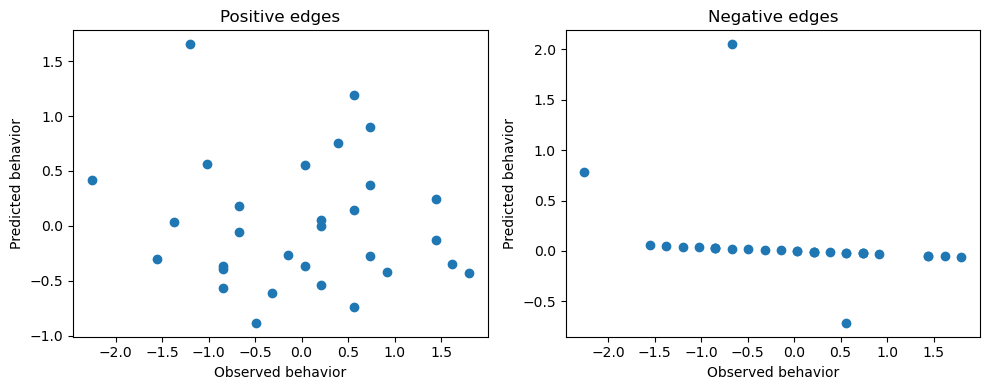

(PearsonRResult(statistic=-0.352532198320799, pvalue=0.056042389996179096),
 PearsonRResult(statistic=-0.09720659221346448, pvalue=0.6093427053047679))

In [122]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# CPM Function
def cpm(X_train, y_train, threshold):
    # 1. INPUTS: Divide the data into training and test sets
    M, N = X_train.shape[1], X_train.shape[0] 
    all_mats, all_behav = X_train, y_train
    all_mats = np.array(all_mats)
    all_behav = np.array(all_behav)

    # Preallocate prediction arrays
    behav_pred_pos = np.zeros((N, 1))
    behav_pred_neg = np.zeros((N, 1))
    
    # 2. CROSS VALIDATION: Perform leave-one-out procedure
    for leftout in range(N):
        print(f'\nLeaving out subj # {leftout + 1:06.3f}')
        start = time.time()

        # Leave out subject from matrices and behavior
        train_mats = np.delete(all_mats, leftout, axis=0)
        train_behav = np.delete(all_behav, leftout, axis=0)

        # 3. RELATE EDGES: Correlate all edges with behavior
        r_mat = np.zeros((M))
        p_mat = np.zeros((M))

        for i in range(M):
            r, p = scipy.stats.pearsonr(train_mats[:, i], train_behav[:])
            r_mat[i] = r
            p_mat[i] = p

        # 4. EDGE SELECTION: Set threshold and define masks
        pos_mask = np.multiply(p_mat < threshold, r_mat > 0)
        neg_mask = np.multiply(p_mat < threshold, r_mat < 0)

        # 5. SINGLE SUBJ SUMMARY VALUES: Compute sum scores
        behav_sum_pos = np.zeros((N - 1, 1))
        behav_sum_neg = np.zeros((N - 1, 1))

        # Divide by two to control for the fact that we're counting each pair twice because the matrix is symmetric
        for i in range(N - 1):
            behav_sum_pos[i] = np.sum(np.multiply(train_mats[i, :], pos_mask))
            behav_sum_neg[i] = np.sum(np.multiply(train_mats[i, :], neg_mask))

        # 6. MODEL FITTING: Fit model on training set
        lin_model_pos = LinearRegression()
        lin_model_pos.fit(behav_sum_pos, train_behav)

        lin_model_neg = LinearRegression()
        lin_model_neg.fit(behav_sum_neg, train_behav)

        # 7. PREDICTION: Predict on left-out subject
        # Extract sum scores for left-out subject
        leftout_sum_pos = np.sum(np.multiply(all_mats[leftout], pos_mask))
        leftout_sum_neg = np.sum(np.multiply(all_mats[leftout], neg_mask))
        leftout_sum_pos = leftout_sum_pos.reshape(1,1)
        leftout_sum_neg = leftout_sum_neg.reshape(1,1)

        # Predict behavior for left-out subject
        behav_pred_pos[leftout] = lin_model_pos.predict(leftout_sum_pos)
        behav_pred_neg[leftout] = lin_model_neg.predict(leftout_sum_neg)

        end = time.time()
        minutes = (end - start) / 60
        seconds = (end - start) % 60

        print(f'This iteration took: {minutes:06.3f} minutes and {seconds:06.3f} seconds')

    # 8. EVALUATION: Compute correlations between predicted and observed behavior
    behav_pred_corr_pos = scipy.stats.pearsonr(all_behav, behav_pred_pos[:, 0])
    behav_pred_corr_neg = scipy.stats.pearsonr(all_behav, behav_pred_neg[:, 0])

    # 9. VISUALIZATION: Make a pretty figure
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(all_behav, behav_pred_pos)
    plt.xlabel('Observed behavior')
    plt.ylabel('Predicted behavior')
    plt.title('Positive edges')
    plt.subplot(1, 2, 2)
    plt.scatter(all_behav, behav_pred_neg)
    plt.xlabel('Observed behavior')
    plt.ylabel('Predicted behavior')
    plt.title('Negative edges')
    plt.tight_layout()
    plt.show()

    return behav_pred_corr_neg, behav_pred_corr_pos

threshold = 0.01
#X_train, X_test, y_train, y_test = train_test_split(X, extrovercy, test_size=0.2, random_state=0)

# compute the CPM
cpm(X, extrovercy, threshold)